<a href="https://colab.research.google.com/github/NhinhDr/CNDPT_PHN/blob/main/NhandienBSX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Giải nén data có sẵn
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/BienSo/data.zip", "r") as nen:
  nen.extractall("/content/drive/MyDrive/BienSo/data")

In [ ]:
#Cài đật thư viện cần thiết
!pip install split-folders
!pip install GPUtil
!pip install xmltodict
!pip install easyocr

In [ ]:
# Các thư viện cần thiết trong dự án
import numpy as np
import cv2
import uuid
import time
import pandas as pd
pd.options.mode.chained_assignment = None
import xmltodict
import glob
import xml.etree.ElementTree as ET
import random as rd
import splitfolders
import easyocr
import PIL
import copy
import shutil
import yaml
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

from pathlib import Path
from sklearn.model_selection import train_test_split
from collections import Counter
from PIL import Image
from tqdm.auto import tqdm
from GPUtil import showUtilization as gpu_usage
from numba import cuda
from timeit import default_timer as timer

import torch
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from matplotlib import patches as mpatches


In [ ]:
# Duyệt dataset
dataset = {
    'file':[],
    'width':[],
    'height':[],
    'xmin':[],
    'ymin':[],
    'xmax':[],
    'ymax':[]
}
img_names = []
annotations = []

for dirname, _, filenames in os.walk('/content/drive/MyDrive/BienSo/data/annotations'):
    for filename in filenames:
        if filename.lower().endswith('.xml'):
            annotations.append(filename)

for dirname, _, filenames in os.walk('/content/drive/MyDrive/BienSo/data/images'):
    for filename in filenames:
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_names.append(filename)


print("Số ảnh:", len(img_names))
print("Số annotation:", len(annotations))
print("Ảnh mẫu:", img_names[:3])
print("Annotation mẫu:", annotations[:3])


Số ảnh: 433
Số annotation: 433
Ảnh mẫu: ['Cars0.png', 'Cars1.png', 'Cars10.png']
Annotation mẫu: ['Cars0.xml', 'Cars1.xml', 'Cars10.xml']


In [ ]:
# Trích xuất thông tin từ annotation
path_annotations = '/content/drive/MyDrive/BienSo/data/annotations/*.xml'

for item in glob.glob(path_annotations):
  tree = ET.parse(item)
  for elem in tree.iter():
    if 'filename' in elem.tag:
      filename = elem.text
    elif 'width' in elem.tag:
      width = int(elem.text)
    elif 'height' in elem.tag:
      height = int(elem.text)
    elif 'xmin' in elem.tag:
      xmin = int(elem.text)
    elif 'ymin' in elem.tag:
      ymin = int(elem.text)
    elif 'xmax' in elem.tag:
      xmax = int(elem.text)
    elif 'ymax' in elem.tag:
      ymax = int(elem.text)
      dataset['file'].append(filename)
      dataset['width'].append(width)
      dataset['height'].append(height)
      dataset['xmin'].append(xmin)
      dataset['ymin'].append(ymin)
      dataset['xmax'].append(xmax)
      dataset['ymax'].append(ymax)
classes = ['license']

df = pd.DataFrame(dataset)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 471 entries, 0 to 470
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   file    471 non-null    object
 1   width   471 non-null    int64 
 2   height  471 non-null    int64 
 3   xmin    471 non-null    int64 
 4   ymin    471 non-null    int64 
 5   xmax    471 non-null    int64 
 6   ymax    471 non-null    int64 
dtypes: int64(6), object(1)
memory usage: 25.9+ KB


In [ ]:
df

,file,width,height,xmin,ymin,xmax,ymax
0,Cars0.png,500,268,226,125,419,173
1,Cars1.png,400,248,134,128,262,160
2,Cars10.png,400,225,140,5,303,148
3,Cars100.png,400,267,175,114,214,131
4,Cars101.png,400,300,167,202,240,220
...,...,...,...,...,...,...,...
466,Cars95.png,600,400,278,182,407,263
467,Cars96.png,400,248,133,126,261,160
468,Cars97.png,400,300,98,102,297,191
469,Cars98.png,370,400,85,196,247,259


In [ ]:
# Tạo khuôn định dạng cho khu vực nhận ảnh
def draw_border(img, pt1, pt2, color, thickness, r, d):
  x1,y1 = pt1
  x2,y2 = pt2

  #Top left
  cv2.line(img, (x1 + r, y1), (x1 + r + d, y1 ), color, thickness)
  cv2.line(img, (x1, y1 + r), (x1, y1 + r + d), color, thickness)
  cv2.ellipse(img, (x2 - r, y1 + r), (r, r), 180, 0, 90, color, thickness)

  #Top right
  cv2.line(img, (x2 - r, y1), (x2 - r - d, y1), color, thickness)
  cv2.line(img, (x2, y1 + r), (x2, y1 + r + d), color, thickness)
  cv2.ellipse(img, (x2 - r, y1 + r), (r, r), 270, 0, 90, color, thickness)

  #Bottom left
  cv2.line(img, (x1 + r, y2), (x1 + r + d, y2), color, thickness)
  cv2.line(img, (x1, y2 - r), (x1, y2 - r - d), color, thickness)
  cv2.ellipse(img, (x1 + r, y2 - r), (r, r), 90, 0, 90, color, thickness)

  #Bottom right
  cv2.line(img, (x2 - r, y2), (x2 - r - d, y2), color, thickness)
  cv2.line(img, (x2, y2 - r), (x2, y2 - r - d), color, thickness)
  cv2.ellipse(img, (x2 - r, y2 - r), (r, r), 0, 0, 90, color, thickness)

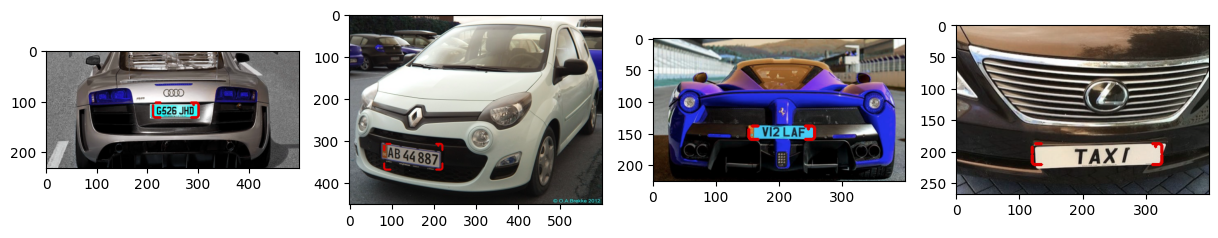

In [ ]:
# Hiển thị 4 ảnh bất kì
def showRandomImage(photos):
  fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (15, 5))
  random_photos = rd.sample(photos, 4)
  for plot_index, image_path in enumerate(random_photos):
    for index, file in enumerate(df.file):
      #Lấy ra thông tin của ảnh (chéo trên/dưới)
      if image_path.split('/')[-1] == file:
        information = list(df.iloc[index, -4:])
        # in thông tin
        image = cv2.imread(image_path)
        draw_border(image,
                          (information[0], information[1]),
                          (information[2], information[3]),
                    (225, 0, 0), 3, 5, 10)
        ax[plot_index].imshow(image)
  plt.show()

photo_path = '/content/drive/MyDrive/BienSo/data/images/*.png'
photo_list = glob.glob(photo_path)
showRandomImage(photo_list)


In [ ]:
x_pos = []
y_pos = []
frame_width = []
frame_height = []

# Tạo thư mục labels: nhãn của mỗi hình ảnh
labels_path = Path('/content/drive/MyDrive/BienSo/data/labels')
labels_path.mkdir(parents=True, exist_ok=True)

# Tạo file dánh nhãn tại thư mục labels
save_type = 'w'
for i, row in enumerate(df.iloc):
  current_filename = str(row.file[:-4])
  width, height, xmin, ymin, xmax, ymax = list(df.iloc[i][-6:])
  x = (xmin + xmax) / 2 / width
  y = (ymin + ymax) / 2 / height
  w = (xmax - xmin) / width
  h = (ymax - ymin) / height
  x_pos.append(x)
  y_pos.append(y)
  frame_width.append(w)
  frame_height.append(h)

  txt = '0'+' '+str(x)+' '+str(y)+' '+str(w)+' '+str(h)+'\n'

  if i > 0:
    perious_filename = str(df.file[i-1][:-4])
    save_type = 'a+' if current_filename == perious_filename else 'w'
  with open('/content/drive/MyDrive/BienSo/data/labels/' + str(row.file[:-4] + '.txt'), save_type) as f:
    f.write(txt)
  f.close()

df['x_pos'] = x_pos
df['y_pos'] = y_pos
df['width'] = frame_width
df['height'] = frame_height

# Để tránh cảnh báo phân mảnh, ta tạo một DataFrame mới
newframe = df.copy()

In [ ]:
df


,file,width,height,xmin,ymin,xmax,ymax,x_pos,y_pos
0,Cars0.png,0.386000,0.179104,226,125,419,173,0.645000,0.555970
1,Cars1.png,0.320000,0.129032,134,128,262,160,0.495000,0.580645
2,Cars10.png,0.407500,0.635556,140,5,303,148,0.553750,0.340000
3,Cars100.png,0.097500,0.063670,175,114,214,131,0.486250,0.458801
4,Cars101.png,0.182500,0.060000,167,202,240,220,0.508750,0.703333
...,...,...,...,...,...,...,...,...,...
466,Cars95.png,0.215000,0.202500,278,182,407,263,0.570833,0.556250
467,Cars96.png,0.320000,0.137097,133,126,261,160,0.492500,0.576613
468,Cars97.png,0.497500,0.296667,98,102,297,191,0.493750,0.488333
469,Cars98.png,0.437838,0.157500,85,196,247,259,0.448649,0.568750


In [ ]:
%cd '/content/drive/MyDrive/BienSo'
!git clone https://github.com/ultralytics/yolov5.git

/content/drive/MyDrive/BienSo
Cloning into 'yolov5'...
remote: Enumerating objects: 17488, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 17488 (delta 0), reused 0 (delta 0), pack-reused 17486 (from 2)
Receiving objects: 100% (17488/17488), 16.54 MiB | 9.33 MiB/s, done.
Resolving deltas: 100% (11988/11988), done.
Updating files: 100% (146/146), done.


In [ ]:
input_folder = Path('/content/drive/MyDrive/BienSo/data')
output_folder = Path('yolov5/data/BienSo')
splitfolders.ratio(
    input_folder,
    output = output_folder,
    seed = 42,
    ratio = (0.8, 0.2),
    group_prefix = None
  )
print('Moving files finished')

Copying files: 1299 files [00:17, 73.47 files/s]

Moving files finished


In [ ]:
# YoloV5 yêu càu một file đó  là .yaml nhằm giúp Yolov5 lúc train xác định được class
# Cần dự đoán, file train nằm ở đâu, file test, validation nằm ở đâu

# Tạo file bien.yaml đúng đường dẫn mới sau khi split
yaml_file = '/content/drive/MyDrive/BienSo/yolov5/data/bien.yaml'
yaml_data = dict(
    path = 'data/BienSo', #folder dataset
    train = 'train',      #folder train trong folder dataset
    val = 'val',          #folder val trong folder dataset
    nc = len(classes),    #số luọng class cần dự đoán
    names = classes       #tên class
)
with open(yaml_file, 'w') as f:
  yaml.dump(yaml_data, f, explicit_start = True, default_flow_style = False)

df.head(5)

,file,width,height,xmin,ymin,xmax,ymax,x_pos,y_pos
0,Cars0.png,0.3860,0.179104,226,125,419,173,0.64500,0.555970
1,Cars1.png,0.3200,0.129032,134,128,262,160,0.49500,0.580645
2,Cars10.png,0.4075,0.635556,140,5,303,148,0.55375,0.340000
3,Cars100.png,0.0975,0.063670,175,114,214,131,0.48625,0.458801
4,Cars101.png,0.1825,0.060000,167,202,240,220,0.50875,0.703333


In [ ]:
df

,file,width,height,xmin,ymin,xmax,ymax,x_pos,y_pos
0,Cars0.png,0.386000,0.179104,226,125,419,173,0.645000,0.555970
1,Cars1.png,0.320000,0.129032,134,128,262,160,0.495000,0.580645
2,Cars10.png,0.407500,0.635556,140,5,303,148,0.553750,0.340000
3,Cars100.png,0.097500,0.063670,175,114,214,131,0.486250,0.458801
4,Cars101.png,0.182500,0.060000,167,202,240,220,0.508750,0.703333
...,...,...,...,...,...,...,...,...,...
466,Cars95.png,0.215000,0.202500,278,182,407,263,0.570833,0.556250
467,Cars96.png,0.320000,0.137097,133,126,261,160,0.492500,0.576613
468,Cars97.png,0.497500,0.296667,98,102,297,191,0.493750,0.488333
469,Cars98.png,0.437838,0.157500,85,196,247,259,0.448649,0.568750


In [ ]:
def free_gpu_cache() -> None:
  print('Inital GPU Usage')
  gpu_usage()
  torch.cuda.empty_cache()
  cuda.select_device(0)
  cuda.close()
  cuda.select_device(0)

  print('GPU Usage after emptying the cache')
  gpu_usage()

free_gpu_cache()

Inital GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  5% |  1% |


In [ ]:
start_time = timer()
%cd '/content/drive/MyDrive/BienSo/yolov5'
!python train.py --img 640 --batch 16 --epochs 100 \
--data '/content/drive/MyDrive/BienSo/yolov5/data/bien.yaml' \
--cfg '/content/drive/MyDrive/BienSo/yolov5/models/yolov5s.yaml' \
--weights '' --name yolov5s_results --workers 2
end_time = timer()
execution_time = end_time - start_time
print(f'Thời gian chạy: {execution_time}')


Streaming output truncated to the last 5000 lines.
2025-06-10 04:55:51.732338: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749531351.971633    4218 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749531352.034122    4218 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train: weights=, cfg=/content/drive/MyDrive/BienSo/yolov5/models/yolov5s.yaml, data=/content/drive/MyDrive/BienSo/yolov5/data/bien.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, bat

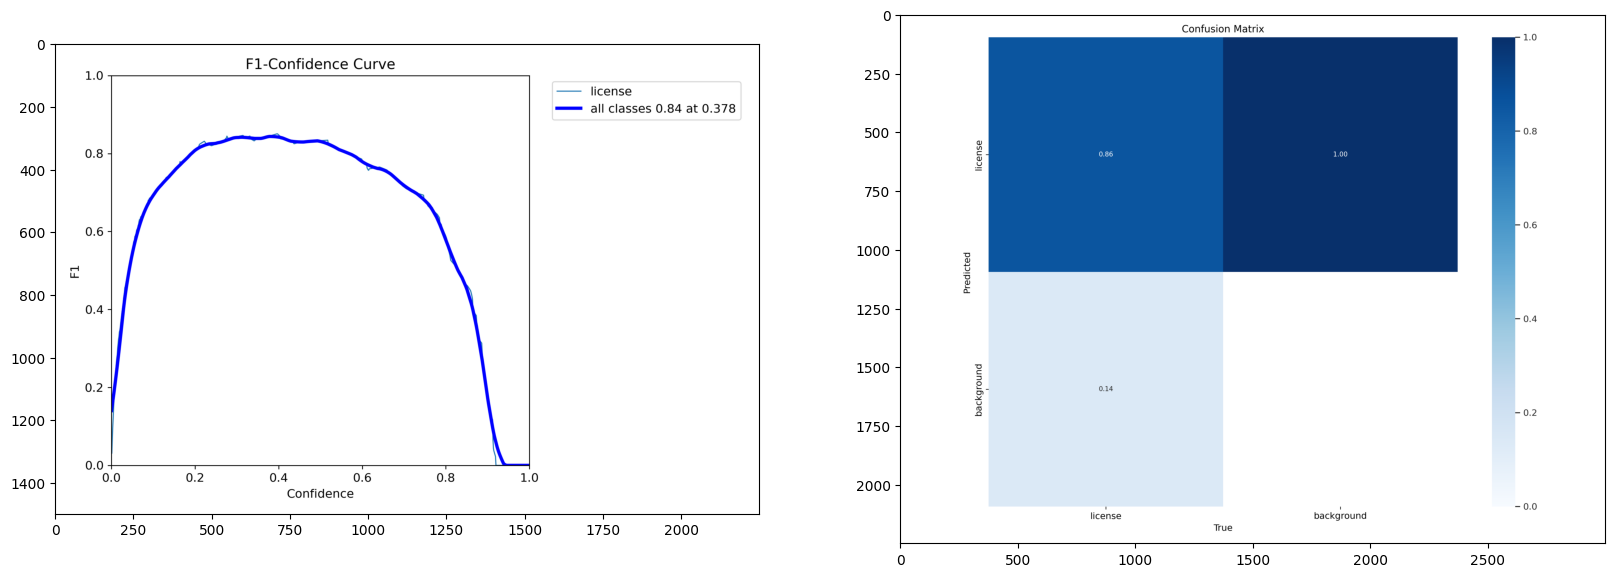

In [ ]:
F1_curve_image = cv2.imread('/content/drive/MyDrive/BienSo/yolov5/runs/train/yolov5s_results/F1_curve.png')
confusion = cv2.imread('/content/drive/MyDrive/BienSo/yolov5/runs/train/yolov5s_results/confusion_matrix.png')
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 10))
ax[0].imshow(F1_curve_image[:,:,::-1])
ax[1].imshow(confusion[:,:,::-1]);

In [ ]:
# Chạy thử
model = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/drive/MyDrive/BienSo/yolov5/runs/train/yolov5s_results/weights/best.pt', force_reload=True)

# Load ảnh test
img_path = '/content/drive/MyDrive/BienSo/data/images/Cars432.png'
img = cv2.imread(img_path)
results = model(img)

# Hiển thị kết quả detect
results.print()
results.show()

# Lấy tọa độ vùng detect
for det in results.xyxy[0]:
    x1, y1, x2, y2, conf, cls = map(int, det[:6])
    # Cắt ảnh biển số
    plate = img[y1:y2, x1:x2]

    # Nhận diện ký tự bằng EasyOCR
    reader = easyocr.Reader(['en'])
    result = reader.readtext(plate)

    # Hiển thị ảnh và kết quả
    plt.imshow(cv2.cvtColor(plate, cv2.COLOR_BGR2RGB))
    plt.title(f'Biển số: {"".join([d[1] for d in result])}')
    plt.axis('off')
    plt.show()

    print(f'Biển số: {"".join([d[1] for d in result])}')


NameError: name 'torch' is not defined

In [ ]:
!git config --global user.email "youremail@gmail.com"
!git config --global user.name "Your Name"